In [2]:
import pandas as pd
from pdvega import Axes as Vega
from vega import VegaLite
from ua_parser import user_agent_parser

# Drawing performance

This notebook analyzes the framerate of the animation for different participants and sessions. Based on this it identifies slow users and sessions.

## Load data

In [3]:
all = pd.read_pickle("outputs/201907111000_duration.pkl", compression="gzip")
users_workers = pd.read_pickle("outputs/201907120900_users_workers_codes.pkl", compression="gzip")
users_who_have_finished = pd.read_pickle("outputs/201907120900_users_who_have_finished.pkl", compression="gzip")

In [4]:
study = all.merge(users_workers, on="user", how="left")
study.loc[study.user.isin(users_who_have_finished), "has_finished"] = True
study.loc[study.has_finished != True, "has_finished"] = False
study.columns

Index(['time', 'source', 'user', 'session', 'userAgent', 'screenWidth',
       'screenHeight', 'windowWidth', 'windowHeight', 'resolution', 'chart',
       'relativePosition', 'absolutePosition', 'message', 'story', 'substory',
       'layout', 'transition', 'condition', 'duration', 'viewing', 'typing',
       'inactive', 'WorkerId', 'code', 'has_finished'],
      dtype='object')

In [5]:
study_time = (study
              .query("chart.str.contains('@') == False")
              .query("transition == 'animated'")
              .copy())
time_diffs = study_time.groupby("session").time.diff()
study_time["time_diff"] = time_diffs
study_time.time_diff = study_time.time_diff.dt.total_seconds()

In [6]:
study_time.session.nunique()

230

## Parameters


We consider differences longer than 0.1 seconds not be caused by slow rendering but rather by the user stopping to interact. Also we consider an acceptable framerate to be 20 fps

In [7]:
interaction_threshold = 0.1 # seconds
acceptable_drawing_time = 0.0333 # seconds

## Framerate

In [8]:
study_time["framerate"] = 1/study_time.time_diff
study_time.framerate.head()

5049          NaN
5050    37.037037
5051    38.461538
5052    55.555556
5053    62.500000
Name: framerate, dtype: float64

## Mean framerate

The mean framerate is 41 fps

In [9]:
(study_time
 .query("time_diff < @interaction_threshold")
 .query('time_diff > 0')
 .time_diff.mean()
)

0.023974889846308554

## Mean framerate per session

In a typical session, the mean framerate is beteen 50 and 25 fps

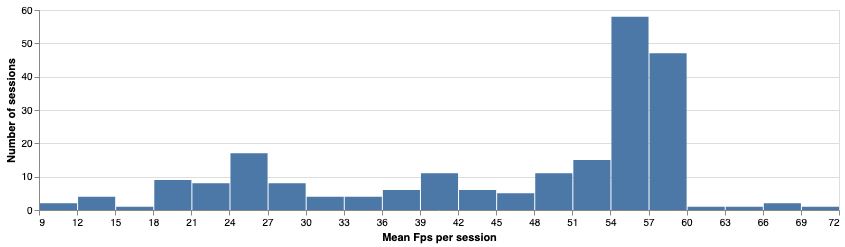

In [10]:
VegaLite({
    "mark": "bar",
    "encoding": {
        "x": {"field": "framerate", "type": "quantitative", "bin": {"step": 3}, "axis": {"title": "Mean Fps per session"}},
        "y": {"aggregate": "count", "axis": {"title": "Number of sessions"}}
    }, "width": 800, "height": 200
}, study_time.query("time_diff < @interaction_threshold").query('time_diff > 0').groupby("session").framerate.mean().reset_index().query("framerate < 70"))

## Slow sessions

We consider a session to slow when the mean drawing performance drops below 20 fps

In [11]:
slow_sessions = (study_time
                 .query("time_diff < @interaction_threshold")
                 .query('time_diff > 0')
                 .groupby("session").time_diff.mean()
                 .reset_index()
                 .query("time_diff > @acceptable_drawing_time")
                 .rename({"time_diff": "mean_drawtime"}, axis=1)
                )
slow_sessions.session.nunique()

55

## Slow users

In [12]:
slow_users = (study
        .query("session.isin(@slow_sessions.session)")
        .groupby(["user"])
        .agg({
            "session": "nunique",
            "userAgent": "first",
            "resolution": "first",
            "screenWidth": "first",
            "screenHeight": "first",
        })
)
slow_users

,session,userAgent,resolution,screenWidth,screenHeight
user,,,,,
1562865729192-0.a9jx3nl92o,4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.20,1280,720
1562868223848-0.r97pivmqcn,1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.25,1536,864
1562890777383-0.vfmh1jrmlw,4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.90,1366,768
1562918465372-0.yboe8j2244t,5,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,1.00,1366,768
1563045696028-0.5uwv2p01pss,4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.50,1280,720
1563046539527-0.5o16g9vu4qw,4,Mozilla/5.0 (X11; CrOS x86_64 12105.75.0) Appl...,1.30,1476,830
1563048176125-0.pt7ykie0f1m,4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.75,1280,800
1563082386380-0.534d3zf0oc4,4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5...,2.00,1680,1050
1563197987583-0.iql1ytbvkg,4,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0.75,1364,768


About 9% of the readers who saw an animated transition had a subpar rendering performance.

In [13]:
slow_users.shape[0] / study.user.nunique()

0.09248554913294797

In [187]:
slow_users.userAgent.apply(lambda x: user_agent_parser.Parse(x)["user_agent"]["family"])

user
1562865729192-0.a9jx3nl92o      Chrome
1562890777383-0.vfmh1jrmlw      Chrome
1562918465372-0.yboe8j2244t     Chrome
1563045696028-0.5uwv2p01pss     Chrome
1563046539527-0.5o16g9vu4qw     Chrome
1563048176125-0.pt7ykie0f1m     Chrome
1563082386380-0.534d3zf0oc4     Chrome
1563197987583-0.iql1ytbvkg      Chrome
1563207606011-0.24yj59vjmcr    Firefox
1563208306000-0.mp9tczpqxsr     Chrome
1563219700860-0.awlgz29jwbq     Chrome
1563264685793-0.xu0285ft8ha     Chrome
1563272429651-0.qwi5ekw7n28     Chrome
1563279849063-0.q1ek6irja8      Chrome
1563291716219-0.g4tnfxsqnt      Chrome
1563301455355-0.l3otdpnqvbj     Chrome
Name: userAgent, dtype: object

In [188]:
slow_users.userAgent.apply(lambda x: user_agent_parser.Parse(x)["os"]["family"])

user
1562865729192-0.a9jx3nl92o       Windows
1562890777383-0.vfmh1jrmlw       Windows
1562918465372-0.yboe8j2244t      Windows
1563045696028-0.5uwv2p01pss      Windows
1563046539527-0.5o16g9vu4qw    Chrome OS
1563048176125-0.pt7ykie0f1m      Windows
1563082386380-0.534d3zf0oc4     Mac OS X
1563197987583-0.iql1ytbvkg       Windows
1563207606011-0.24yj59vjmcr      Windows
1563208306000-0.mp9tczpqxsr      Windows
1563219700860-0.awlgz29jwbq     Mac OS X
1563264685793-0.xu0285ft8ha      Windows
1563272429651-0.qwi5ekw7n28      Windows
1563279849063-0.q1ek6irja8      Mac OS X
1563291716219-0.g4tnfxsqnt       Windows
1563301455355-0.l3otdpnqvbj      Windows
Name: userAgent, dtype: object

## Export

In [195]:
slow_sessions.to_pickle("outputs/201907121600_slow_sessions.pkl", compression="gzip")